In [2]:
import torch_geometric.transforms as T
import os.path as osp
from torch_geometric.datasets import Planetoid
from sklearn.manifold import TSNE
import torch

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps
from matplotlib.patches import Ellipse
import seaborn as sns
import plotly.express as px

In [3]:
# Calculate the area between ROC and y=x line

def compute_area_above_below_curve(x, y):
    area_above = 0.0
    area_below = 0.0
    
    for i in range(1, len(x)):
        x0, x1 = x[i - 1], x[i]
        y0, y1 = y[i - 1], y[i]
        line0, line1 = x0, x1  # Since line y = x
        
        if y1 == y0:  # Vertical segment
            if y0 > x0:
                area_above += (y0 - x0) * (x1 - x0)
            else:
                area_below += (x0 - y0) * (x1 - x0)
            continue
        
        # Find intersection with y = x
        if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
            if y0 >= x0 and y1 >= x1:
                area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
            else:
                area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
        else:
            x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
            if y0 < x0:
                area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
                area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
            else:
                area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
                area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)
    
    return area_above, area_below



In [4]:
# Network generation --------------------------------------------------------
random.seed(10)
np.random.seed(10)

n = 1000  # number of nodes
K = 4   # number of node communities

# Community labels
tau = np.random.choice(K, n) # order tau would make the nice blocks
tau = np.sort(tau)
# print(tau)

# Generate stochastic block model (SBM) B matrix
"""Just one observation is required"""
B_list = []

B_list.append(np.array([[0.8, 0.1, 0.5, 0.3],
                        [0.4, 0.6, 0.9, 0.2],
                        [0.7, 0.2, 0.4, 0.8],
                        [0.3, 0.5, 0.6, 0.1]]))

# Generate adjacency matrix from the B matrix
As = np.zeros((n, n))
P_list = []

random.seed(100)
np.random.seed(100)

# Get probability matrix from B
P_t = np.column_stack(
    [B_list[0][tau, tau[i]] for i in range(n)])
P_list.append(P_t)

# Generate random graph from the P matrix
A_t = np.random.binomial(n=1, p=P_t)
# turn to integer from float
A_t = A_t.astype(int)
As = A_t

# As = As.astype(int)
P = np.column_stack(P_list)

# choose d
d=4

In [5]:
# obs_adj is the observed adjacency matrix
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

k = 5
B = 30

p_vals = []
A_boots_list = []

for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_bootstrap(As.astype(float), d=d, Q=1000, n_neighbors=k)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


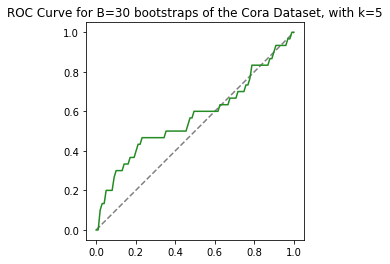

Total area (above and below y=x): 0.0848327165131573 for k=5


In [6]:
# Provided code
p_hat_list = p_vals
roc = []
alphas = []

for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]

plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title(f"ROC Curve for B={B} bootstraps of the Cora Dataset, with k={k}")
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

# Find the area between the ROC curve and the y=x line
x = np.linspace(0, 1, 100)
roc_interpolated = np.interp(x, alphas, roc)

# Compute areas
area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
total_area = area_above + area_below

print(f"Total area (above and below y=x): {total_area} for k={k}")

In [7]:
A_list = [As.astype(float)] + A_boots_list
len(A_list)

yhat = UASE(A_list, d=d, sparse_matrix=False)

In [8]:
yadf = pd.DataFrame(yhat)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = (tau.tolist())*(B+1)

# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B+1), len(tau))

In [9]:
fig = px.scatter(yadf, 
                 x='Dimension_1', 
                 y='Dimension_2', 
                 color='tau', 
                 animation_frame='Matrix')
fig.show()

In [10]:
# tsne this embedding
tsne = TSNE(n_components=2, perplexity=30, random_state=0)

yhat_tsne = tsne.fit_transform(yhat)

In [11]:
yhat_tsne_df = pd.DataFrame(yhat_tsne, columns=["Dimension_1", "Dimension_2"])

In [12]:
yhat_tsne_df = pd.DataFrame(yhat_tsne)
# rename the columns
yhat_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(yhat_tsne_df.shape[1])] 
# add column for the matrix it is
yhat_tsne_df["Matrix"] = np.repeat(range(B+1), len(tau))
# repeats tau list the len of A_true_boots_list times
yhat_tsne_df["tau"] = (tau.tolist()*(B+1))

yhat_tsne_df0 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 0]
yhat_tsne_df1 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 1]

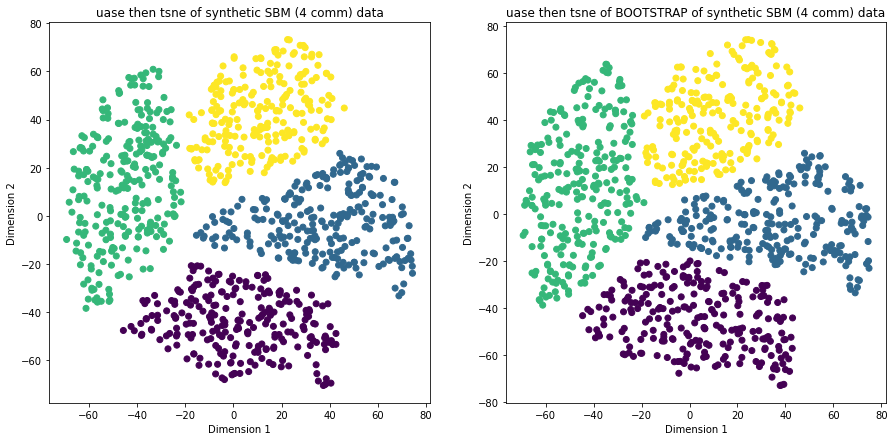

In [13]:
# plot two figures for the two different dfs side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# plot the first df
scatter = ax1.scatter(yhat_tsne_df0["Dimension_1"], yhat_tsne_df0["Dimension_2"], c=yhat_tsne_df0["tau"], cmap='viridis')
ax1.set_title("uase then tsne of synthetic SBM (4 comm) data")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")

# plot the second df
scatter = ax2.scatter(yhat_tsne_df1["Dimension_1"], yhat_tsne_df1["Dimension_2"], c=yhat_tsne_df1["tau"], cmap='viridis')
ax2.set_title("uase then tsne of BOOTSTRAP of synthetic SBM (4 comm) data")
ax2.set_xlabel("Dimension 1")
ax2.set_ylabel("Dimension 2")

# plt.colorbar(scatter)
plt.show()

/home/uj21900/anaconda3/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning:

The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.



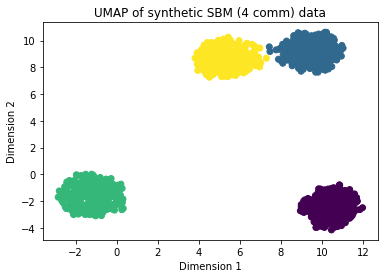

In [14]:
# JUST APPLY UMAP TO A_obs
import umap

umap_obj = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='euclidean')
yhat_umap = umap_obj.fit_transform(As)

yhat_umap_df = pd.DataFrame(yhat_umap, columns=["Dimension_1", "Dimension_2"])

# plot
plt.scatter(yhat_umap_df["Dimension_1"], yhat_umap_df["Dimension_2"], c=tau, cmap='viridis')
plt.title("UMAP of synthetic SBM (4 comm) data")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

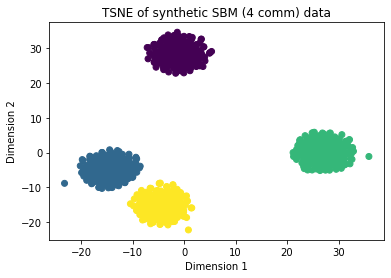

In [15]:
# JUST APPLY TSNE TO A_obs

As_tsne = tsne.fit_transform(As)

As_tsne_df = pd.DataFrame(As_tsne, columns=["Dimension_1", "Dimension_2"])

# plot
plt.scatter(As_tsne_df["Dimension_1"], As_tsne_df["Dimension_2"], c=tau, cmap='viridis')
plt.title("TSNE of synthetic SBM (4 comm) data")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()